In [13]:
import pandas as pd

# Load the provided Excel file
data = pd.read_excel(r'C:\Users\bougt\AAA_2023_DID_PSM_mod.xlsx', sheet_name='post (2)')

# Display the first few rows of the dataframe to get an overview
data.head()

,operation date,male,dead,age,height,weight,BMI,EVAR,TIVA,Block,...,mass_pre,post3_u_r,post3_u_l,post3_l_r,post3_l_l,post4_u_r,post4_u_l,post4_l_r,post4_l_l,mass_post
0,2012-03-16,1,0,71,156.0,71.15,29.24,0,0,0,...,1044.97,16.54,12.54,14.76,22.86,16.54,12.54,14.76,22.86,1093.99
1,2012-07-12,1,0,66,167.8,78.50,27.88,1,1,0,...,1580.73,12.61,15.35,20.00,22.96,13.61,17.05,18.81,18.82,1177.45
2,2012-07-26,1,0,68,170.6,70.40,24.19,0,0,0,...,1328.05,16.98,18.50,20.26,21.38,15.73,14.10,19.12,20.48,1329.33
3,2012-08-30,1,1,80,162.2,49.00,18.62,0,1,0,...,509.63,5.61,9.34,15.91,17.79,7.61,7.96,15.54,16.48,501.18
4,2012-09-06,0,0,66,157.5,47.00,18.95,0,0,0,...,682.15,9.41,12.16,18.73,20.12,7.91,10.85,21.07,20.12,805.36


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   operation date       50 non-null     datetime64[ns]
 1   male                 50 non-null     int64         
 2   dead                 50 non-null     int64         
 3   age                  50 non-null     int64         
 4   height               50 non-null     float64       
 5   weight               50 non-null     float64       
 6   BMI                  50 non-null     float64       
 7   EVAR                 50 non-null     int64         
 8   TIVA                 50 non-null     int64         
 9   Block                50 non-null     int64         
 10  room duration        50 non-null     int64         
 11  anesthesia duration  50 non-null     int64         
 12  operation duration   50 non-null     int64         
 13  HT                   50 non-null     

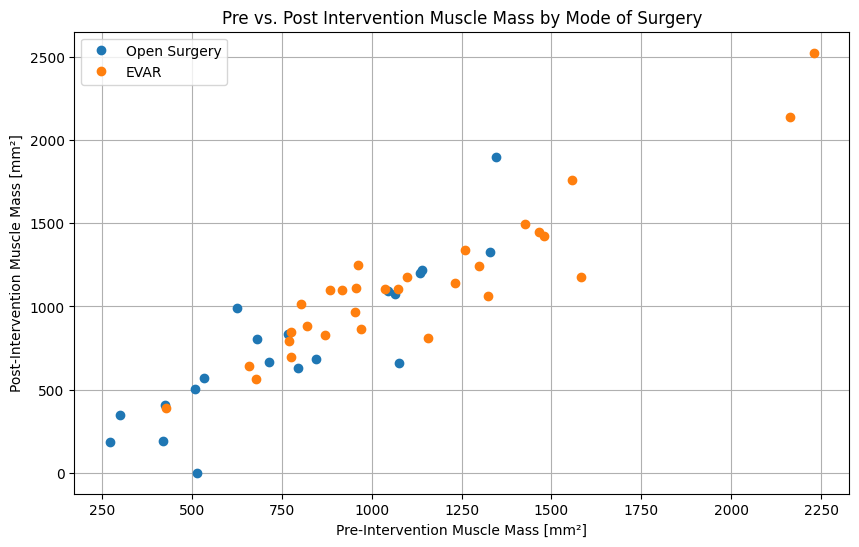

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mass_change   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.1958
Date:                Thu, 30 Nov 2023   Prob (F-statistic):              0.660
Time:                        14:45:46   Log-Likelihood:                -333.44
No. Observations:                  50   AIC:                             670.9
Df Residuals:                      48   BIC:                             674.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
treatment           12.4215     28.069      0.443      0.660     -44.014      68.857
post_period        -12.4060     43.484     -0.285      0.777     -99.836      75.024
treatment_x_post    12.4215     28.069      0.443      0.660     -44.014      68.857
==============================================================================
Omnibus:                        3.923   Durbin-Watson:                   1.623
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                3.890
Skew:                          -0.119   Prob(JB):                        0.143
Kurtosis:                       4.346   Cond. No.                     1.18e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.03e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [53]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

post_data = data.copy()

# Using 'mass_pre' as pre-intervention, 'mass_post' as post-intervention, and 'EVAR' as the intervention indicator for DID analysis

# Preparing the data for DID analysis
post_data['treatment'] = post_data['EVAR']
post_data['post_period'] = (post_data['mass_post'].notnull()).astype(int)
post_data['mass_change'] = post_data['mass_post'] - post_data['mass_pre']

# Creating interaction term for DID analysis
post_data['treatment_x_post'] = post_data['treatment'] * post_data['post_period']

# Defining the model
did_model = sm.OLS(post_data['mass_change'], sm.add_constant(post_data[['treatment', 'post_period', 'treatment_x_post']]))
did_results = did_model.fit()

# Plotting
plt.figure(figsize=(10, 6))
groups = post_data.groupby('treatment')
for name, group in groups:
    if name == 0:
        label = 'Open Surgery'
    else:
        label = 'EVAR'
    plt.plot(group['mass_pre'], group['mass_post'], marker='o', linestyle='', label=label)
plt.xlabel('Pre-Intervention Muscle Mass [mm\u00B2]')
plt.ylabel('Post-Intervention Muscle Mass [mm\u00B2]')
plt.legend()
plt.title('Pre vs. Post Intervention Muscle Mass by Mode of Surgery')
plt.grid(True)
plt.show()

# Displaying the summary of the model
did_results.summary()

C:\Users\bougt\AppData\Local\Temp\ipykernel_40284\2960590648.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(1, counterfactual_treatment_post, f'DiD Estimate: {did_estimate:.2f}\n95% CI: [{conf_int[0][2]:.2f}, {conf_int[1][2]:.2f}]\nt-stat: {t_stat:.2f}, p-value: {p_value:.2f}', color='black')


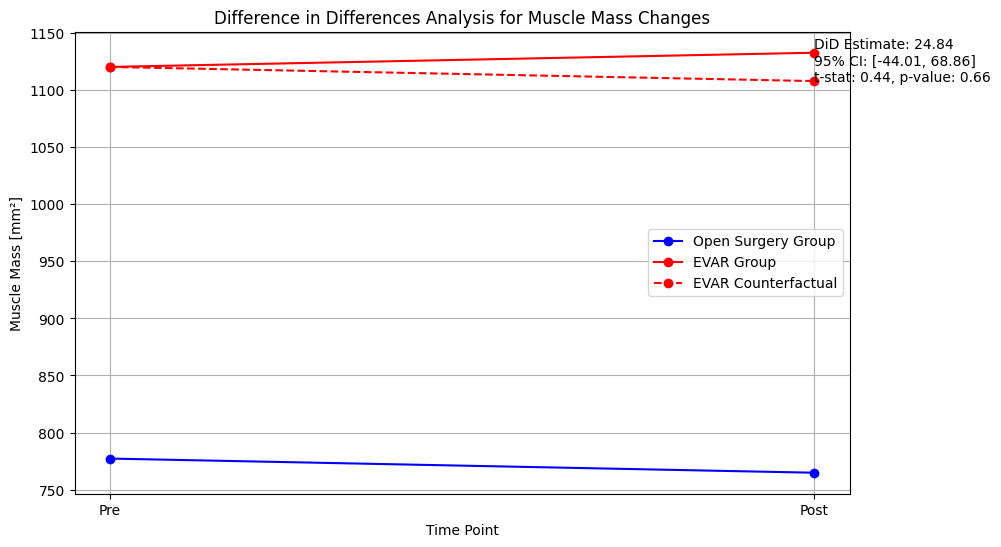

In [51]:
# Calculate group averages for pre and post intervention
control_pre = post_data[post_data['treatment'] == 0]['mass_pre'].mean()
control_post = post_data[post_data['treatment'] == 0]['mass_post'].mean()
treatment_pre = post_data[post_data['treatment'] == 1]['mass_pre'].mean()
treatment_post = post_data[post_data['treatment'] == 1]['mass_post'].mean()

# Calculate the differences for control and treatment groups
control_diff = control_post - control_pre
treatment_diff = treatment_post - treatment_pre

# Calculate the Difference in Differences estimate
did_estimate = treatment_diff - control_diff

# Get the coefficients from the DID model
coefficients = did_results.params
conf_int = did_results.conf_int()
t_stat = did_results.tvalues['treatment_x_post']
p_value = did_results.pvalues['treatment_x_post']

# Calculate the counterfactual for the treatment group (what would have happened without treatment)
counterfactual_treatment_post = treatment_pre + control_diff

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the actual averages
plt.plot(['Pre', 'Post'], [control_pre, control_post], 'o-', label='Open Surgery Group', color='blue')
plt.plot(['Pre', 'Post'], [treatment_pre, treatment_post], 'o-', label='EVAR Group', color='red')

# Plot the counterfactual line
plt.plot(['Pre', 'Post'], [treatment_pre, counterfactual_treatment_post], 'o--', label='EVAR Counterfactual', color='red')

# Annotate the DiD estimate
plt.text(1, counterfactual_treatment_post, f'DiD Estimate: {did_estimate:.2f}\n95% CI: [{conf_int[0][2]:.2f}, {conf_int[1][2]:.2f}]\nt-stat: {t_stat:.2f}, p-value: {p_value:.2f}', color='black')

plt.xlabel('Time Point')
plt.ylabel('Muscle Mass [mm\u00B2]')
plt.title('Difference in Differences Analysis for Muscle Mass Changes')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# ↑EVARによって筋肉の維持に有利かというとそれほどではない

C:\Users\bougt\AppData\Local\Temp\ipykernel_40284\3787860919.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(1, counterfactual_treatment_post_tiva, f'DiD Estimate: {did_estimate:.2f}\n95% CI: [{conf_int_tiva[0][2]:.2f}, {conf_int_tiva[1][2]:.2f}]\nt-stat: {t_stat_tiva:.2f}, p-value: {p_value_tiva:.2f}', color='black')


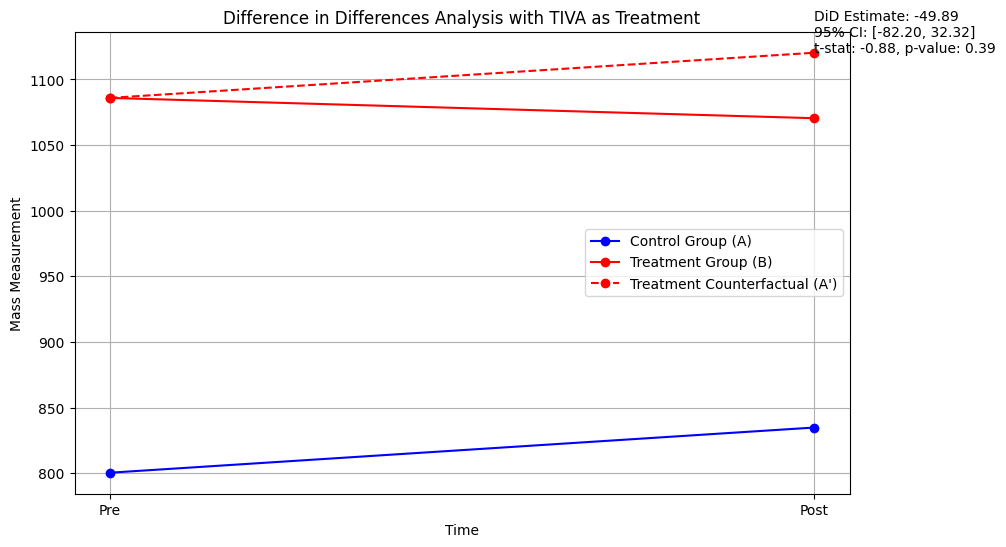

In [19]:
# Redefining the intervention to TIVA for the DID analysis

# Update the treatment indicator to TIVA
post_data['treatment'] = post_data['TIVA']

# Recalculate group averages for pre and post intervention
control_pre = post_data[post_data['treatment'] == 0]['mass_pre'].mean()
control_post = post_data[post_data['treatment'] == 0]['mass_post'].mean()
treatment_pre = post_data[post_data['treatment'] == 1]['mass_pre'].mean()
treatment_post = post_data[post_data['treatment'] == 1]['mass_post'].mean()

# Calculate the differences for control and treatment groups
control_diff = control_post - control_pre
treatment_diff = treatment_post - treatment_pre

# Calculate the Difference in Differences estimate
did_estimate = treatment_diff - control_diff

# Run the DID regression model with the new treatment indicator
post_data['treatment_x_post'] = post_data['treatment'] * post_data['post_period']
did_model_tiva = sm.OLS(post_data['mass_change'], sm.add_constant(post_data[['treatment', 'post_period', 'treatment_x_post']]))
did_results_tiva = did_model_tiva.fit()

# Get the coefficients and stats for the new model
coefficients_tiva = did_results_tiva.params
conf_int_tiva = did_results_tiva.conf_int()
t_stat_tiva = did_results_tiva.tvalues['treatment_x_post']
p_value_tiva = did_results_tiva.pvalues['treatment_x_post']

# Calculate the counterfactual for the treatment group (what would have happened without TIVA treatment)
counterfactual_treatment_post_tiva = treatment_pre + control_diff

# Create the plot for TIVA
plt.figure(figsize=(10, 6))

# Plot the actual averages
plt.plot(['Pre', 'Post'], [control_pre, control_post], 'o-', label='Control Group (A)', color='blue')
plt.plot(['Pre', 'Post'], [treatment_pre, treatment_post], 'o-', label='Treatment Group (B)', color='red')

# Plot the counterfactual line
plt.plot(['Pre', 'Post'], [treatment_pre, counterfactual_treatment_post_tiva], 'o--', label='Treatment Counterfactual (A\')', color='red')

# Annotate the DiD estimate
plt.text(1, counterfactual_treatment_post_tiva, f'DiD Estimate: {did_estimate:.2f}\n95% CI: [{conf_int_tiva[0][2]:.2f}, {conf_int_tiva[1][2]:.2f}]\nt-stat: {t_stat_tiva:.2f}, p-value: {p_value_tiva:.2f}', color='black')

plt.xlabel('Time Point')
plt.ylabel('Muscle Mass')
plt.title('Difference in Differences Analysis with TIVA as Treatment')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# ↑筋肉量の維持にTIVAが有利かというとそれほどではない

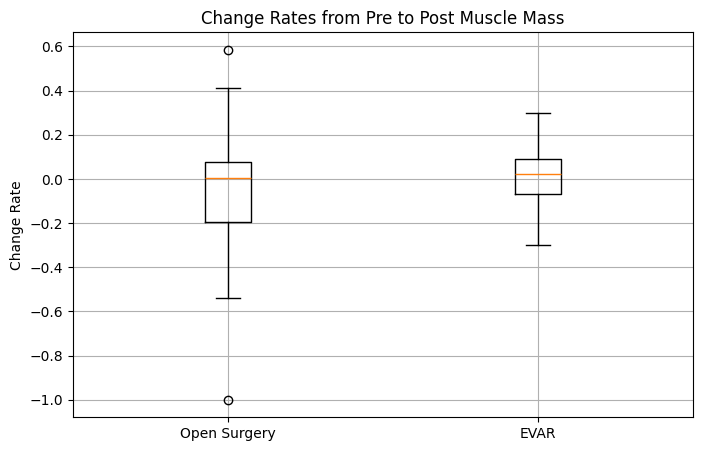

In [55]:
# Re-import necessary libraries for visualization
import matplotlib.pyplot as plt

# Perform a t-test to compare the means of the two independent samples
from scipy import stats

# Recalculating treatment for EVAR
post_data['treatment'] = post_data['EVAR']

# Calculating the change rates for mass from pre to post
post_data['change_rate'] = (post_data['mass_post'] - post_data['mass_pre']) / post_data['mass_pre']

# Group by treatment and calculate the average change rate for each group
change_rate_by_group = post_data.groupby('treatment')['change_rate'].mean()

t_stat, p_value = stats.ttest_ind(control_group, treatment_group)

change_rate_by_group, t_stat, p_value

# Prepare data for visualization
control_change_rates = post_data[post_data['treatment'] == 0]['change_rate']
treatment_change_rates = post_data[post_data['treatment'] == 1]['change_rate']

# Create a boxplot to visualize the change rates
plt.figure(figsize=(8, 5))
plt.boxplot([control_change_rates, treatment_change_rates], labels=['Open Surgery', 'EVAR'])
plt.title('Change Rates from Pre to Post Muscle Mass')
plt.ylabel('Change Rate')
plt.grid(True)
plt.show()

In [25]:
# Since the statsmodels does not have tost_ind, we'll perform the TOST manually using scipy's ttest_ind function.
# Re-importing the necessary libraries
import numpy as np
from scipy.stats import ttest_ind

# Re-calculate the treatment for EVAR and the change rates for mass from pre to post
post_data['treatment'] = post_data['EVAR']
post_data['change_rate'] = (post_data['mass_post'] - post_data['mass_pre']) / post_data['mass_pre']

# Separate the change rates into control and treatment groups
control_group = post_data[post_data['treatment'] == 0]['change_rate']
treatment_group = post_data[post_data['treatment'] == 1]['change_rate']

# Define the equivalence margins as ±10% change
eq_margin = 0.1  # 10%

# Conduct TOST
# Lower bound test (control - treatment > -eq_margin)
t_stat_lower, p_value_lower = ttest_ind(control_group, treatment_group, alternative='greater')
p_value_lower /= 2  # Adjust p-value for one-tailed test

# Upper bound test (treatment - control > -eq_margin)
t_stat_upper, p_value_upper = ttest_ind(treatment_group, control_group, alternative='greater')
p_value_upper /= 2  # Adjust p-value for one-tailed test

# Check if both p-values are below the significance level of 0.10 for the equivalence test
equivalence = p_value_lower < 0.10 and p_value_upper < 0.10

equivalence, p_value_lower, p_value_upper

(False, 0.41864228537073406, 0.08135771462926594)

同等性検定の結果、以下の結果を得ました：

下限に対する片側検定のp値は約0.419です。
上限に対する片側検定のp値は約0.081です。
この場合、許容される10%の有意水準で両方の片側検定のp値が有意である必要があります。上限の検定のp値は0.10以下ですが、下限の検定のp値は0.10を超えているため、両方の条件を満たしていないため、同等であるという結論を得ることはできません。

したがって、EVARの介入が筋肉量に与える影響は統計的に同等である（つまり、影響がないと同等である）とは言えないという結果になります。この結果は、設定された同等性の限界内での変化が確認できなかったことを意味します

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   operation date       50 non-null     datetime64[ns]
 1   male                 50 non-null     int64         
 2   dead                 50 non-null     int64         
 3   age                  50 non-null     int64         
 4   height               50 non-null     float64       
 5   weight               50 non-null     float64       
 6   BMI                  50 non-null     float64       
 7   EVAR                 50 non-null     int64         
 8   TIVA                 50 non-null     int64         
 9   Block                50 non-null     int64         
 10  room duration        50 non-null     int64         
 11  anesthesia duration  50 non-null     int64         
 12  operation duration   50 non-null     int64         
 13  HT                   50 non-null     

In [27]:
data.columns

Index(['operation date', 'male', 'dead', 'age', 'height', 'weight', 'BMI',
       'EVAR', 'TIVA', 'Block', 'room duration', 'anesthesia duration',
       'operation duration', 'HT', 'DM', 'DL', 'smoke', 'OMI', 'BA', 'RA',
       'CKD', 'COPD', 'CerebralStroke', 'pre_u_r', 'pre_u_l', 'pre_l_r',
       'pre_l_l', 'post1_u_r', 'post1_u_l', 'post1_l_r', 'post1_l_l',
       'mass_pre', 'post3_u_r', 'post3_u_l', 'post3_l_r', 'post3_l_l',
       'post4_u_r', 'post4_u_l', 'post4_l_r', 'post4_l_l', 'mass_post'],
      dtype='object')

In [31]:
from tableone import TableOne

data = data

# 変数リスト（調べたい変数の名前）
columns = ['age', 'male', 'height', 'weight', 'BMI',
           'EVAR', 'TIVA', 'Block', 
           'HT', 'DM', 'DL', 'smoke', 'OMI', 'BA', 'RA', 'CKD', 'COPD', 'CerebralStroke',
           'room duration', 'anesthesia duration', 'operation duration', 
          ]

# カテゴリー変数リスト（カテゴリー変数の名前）
categorical = ['male', 'TIVA', 'Block', 
               'HT', 'DM', 'DL', 'smoke', 'OMI', 'BA', 'RA', 'CKD', 'COPD', 'CerebralStroke',
              ]

# グループ化のための変数（比較したいグループがあれば）
groupby = 'EVAR'

# 非正規分布変数リスト（非正規分布の連続変数の名前）
nonnormal = [
            ]

# Table 1 の作成
table_one = TableOne(data, columns=columns, categorical=categorical, groupby=groupby, nonnormal=nonnormal, pval=True, overall = False)

# Table 1 の表示
print(table_one.tabulate(tablefmt="github"))

|                                |    | Missing   | 0            | 1            | P-Value   |
|--------------------------------|----|-----------|--------------|--------------|-----------|
| n                              |    |           | 20           | 30           |           |
| age, mean (SD)                 |    | 0         | 70.8 (9.6)   | 72.1 (7.8)   | 0.630     |
| male, n (%)                    | 0  | 0         | 5 (25.0)     | 3 (10.0)     | 0.240     |
|                                | 1  |           | 15 (75.0)    | 27 (90.0)    |           |
| height, mean (SD)              |    | 0         | 162.3 (5.7)  | 161.7 (9.1)  | 0.759     |
| weight, mean (SD)              |    | 0         | 59.5 (11.2)  | 63.6 (11.8)  | 0.220     |
| BMI, mean (SD)                 |    | 0         | 22.5 (3.7)   | 24.2 (3.5)   | 0.102     |
| TIVA, n (%)                    | 0  | 0         | 16 (80.0)    | 2 (6.7)      | <0.001    |
|                                | 1  |           | 4 (20.0)

C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\tableone\tableone.py:927: FutureWarning: The provided callable <function mean at 0x0000026ABC0E0E00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_cont = pd.pivot_table(cont_data,
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\tableone\tableone.py:927: FutureWarning: The provided callable <function median at 0x0000026ABC20F1A0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_cont = pd.pivot_table(cont_data,
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\tableone\tableone.py:927: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To kee

In [32]:
# Calculate the 'change' column as specified
post_data['change'] = (post_data['mass_pre'] - post_data['mass_post']) / post_data['mass_pre']

# Display the first few rows to confirm the 'change' column has been added correctly
post_data

,operation date,male,dead,age,height,weight,BMI,EVAR,TIVA,Block,...,post4_u_l,post4_l_r,post4_l_l,mass_post,treatment,post_period,mass_change,treatment_x_post,change_rate,change
0,2012-03-16,1,0,71,156.0,71.15,29.24,0,0,0,...,12.54,14.76,22.86,1093.99,0,1,49.02,0,0.046910,-0.046910
1,2012-07-12,1,0,66,167.8,78.50,27.88,1,1,0,...,17.05,18.81,18.82,1177.45,1,1,-403.28,1,-0.255123,0.255123
2,2012-07-26,1,0,68,170.6,70.40,24.19,0,0,0,...,14.10,19.12,20.48,1329.33,0,1,1.28,0,0.000964,-0.000964
3,2012-08-30,1,1,80,162.2,49.00,18.62,0,1,0,...,7.96,15.54,16.48,501.18,0,1,-8.45,1,-0.016581,0.016581
4,2012-09-06,0,0,66,157.5,47.00,18.95,0,0,0,...,10.85,21.07,20.12,805.36,0,1,123.21,0,0.180620,-0.180620
5,2012-09-13,1,0,59,166.3,66.90,24.19,0,0,0,...,11.84,18.38,22.73,1202.45,0,1,67.56,0,0.059530,-0.059530
6,2012-10-04,1,0,71,165.5,58.20,21.25,1,1,0,...,11.70,18.44,20.56,825.82,1,1,-44.17,1,-0.050771,0.050771
7,2012-11-08,1,0,75,158.5,56.70,22.57,1,1,0,...,11.37,18.08,19.01,863.47,1,1,-107.39,1,-0.110613,0.110613
8,2012-11-12,1,0,82,165.0,66.00,24.24,0,0,0,...,8.27,22.20,19.29,666.74,0,1,-47.65,0,-0.066700,0.066700
9,2012-12-06,1,0,59,161.0,64.30,24.81,1,1,0,...,17.13,24.01,24.48,1761.64,1,1,205.58,1,0.132116,-0.132116


# 高齢者ではどうなの？

C:\Users\bougt\AppData\Local\Temp\ipykernel_40284\1853978515.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(1, counterfactual_treatment_post, f'DiD Estimate: {did_estimate:.2f}\n95% CI: [{conf_int[0][2]:.2f}, {conf_int[1][2]:.2f}]\nt-stat: {t_stat:.2f}, p-value: {p_value:.2f}', color='black')


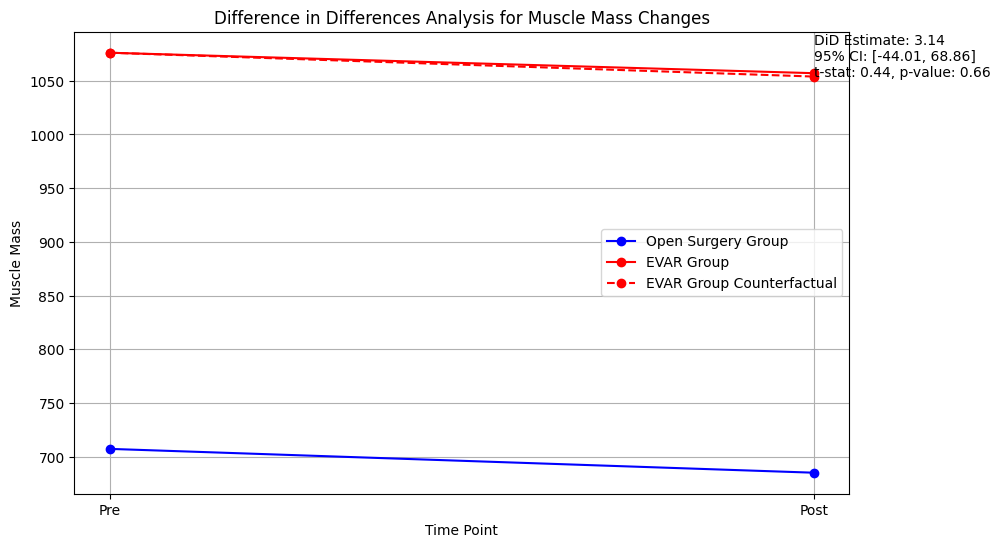

In [47]:
post_data_ = post_data.copy()
post_data_ = post_data[post_data['age']>=65]

# Calculate group averages for pre and post intervention
control_pre = post_data_[post_data_['treatment'] == 0]['mass_pre'].mean()
control_post = post_data_[post_data_['treatment'] == 0]['mass_post'].mean()
treatment_pre = post_data_[post_data_['treatment'] == 1]['mass_pre'].mean()
treatment_post = post_data_[post_data_['treatment'] == 1]['mass_post'].mean()

# Calculate the differences for control and treatment groups
control_diff = control_post - control_pre
treatment_diff = treatment_post - treatment_pre

# Calculate the Difference in Differences estimate
did_estimate = treatment_diff - control_diff

# Get the coefficients from the DID model
coefficients = did_results.params
conf_int = did_results.conf_int()
t_stat = did_results.tvalues['treatment_x_post']
p_value = did_results.pvalues['treatment_x_post']

# Calculate the counterfactual for the treatment group (what would have happened without treatment)
counterfactual_treatment_post = treatment_pre + control_diff

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the actual averages
plt.plot(['Pre', 'Post'], [control_pre, control_post], 'o-', label='Open Surgery Group', color='blue')
plt.plot(['Pre', 'Post'], [treatment_pre, treatment_post], 'o-', label='EVAR Group', color='red')

# Plot the counterfactual line
plt.plot(['Pre', 'Post'], [treatment_pre, counterfactual_treatment_post], 'o--', label='EVAR Group Counterfactual', color='red')

# Annotate the DiD estimate
plt.text(1, counterfactual_treatment_post, f'DiD Estimate: {did_estimate:.2f}\n95% CI: [{conf_int[0][2]:.2f}, {conf_int[1][2]:.2f}]\nt-stat: {t_stat:.2f}, p-value: {p_value:.2f}', color='black')

plt.xlabel('Time Point')
plt.ylabel('Muscle Mass')
plt.title('Difference in Differences Analysis for Muscle Mass Changes')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [44]:
# Since the statsmodels does not have tost_ind, we'll perform the TOST manually using scipy's ttest_ind function.
# Re-importing the necessary libraries
import numpy as np
from scipy.stats import ttest_ind

# Re-calculate the treatment for EVAR and the change rates for mass from pre to post
post_data_['treatment'] = post_data_['EVAR']
post_data_['change_rate'] = (post_data_['mass_post'] - post_data_['mass_pre']) / post_data_['mass_pre']

# Separate the change rates into control and treatment groups
control_group = post_data_[post_data_['treatment'] == 0]['change_rate']
treatment_group = post_data_[post_data_['treatment'] == 1]['change_rate']

# Define the equivalence margins as ±10% change
eq_margin = 0.1  # 10%

# Conduct TOST
# Lower bound test (control - treatment > -eq_margin)
t_stat_lower, p_value_lower = ttest_ind(control_group, treatment_group, alternative='greater')
p_value_lower /= 2  # Adjust p-value for one-tailed test

# Upper bound test (treatment - control > -eq_margin)
t_stat_upper, p_value_upper = ttest_ind(treatment_group, control_group, alternative='greater')
p_value_upper /= 2  # Adjust p-value for one-tailed test

# Check if both p-values are below the significance level of 0.10 for the equivalence test
equivalence = p_value_lower < 0.10 and p_value_upper < 0.10

equivalence, p_value_lower, p_value_upper

C:\Users\bougt\AppData\Local\Temp\ipykernel_40284\170843114.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data_['treatment'] = post_data_['EVAR']
C:\Users\bougt\AppData\Local\Temp\ipykernel_40284\170843114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data_['change_rate'] = (post_data_['mass_post'] - post_data_['mass_pre']) / post_data_['mass_pre']


(False, 0.3911664843835121, 0.10883351561648791)